## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


## Load the dataset

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data.rename(columns={'v1': 'label', 'v2': 'message'})

In [3]:
# Dropping unnecessary columns
data = data[['label', 'message']]
data 

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Data Exploration

In [4]:
# Display the first few rows
print(data.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
# Summary of the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [6]:
# Checking for missing values
print(data.isnull().sum())

label      0
message    0
dtype: int64


In [7]:
# Label distribution
label_distribution = data['label'].value_counts()
print(label_distribution)

label
ham     4825
spam     747
Name: count, dtype: int64


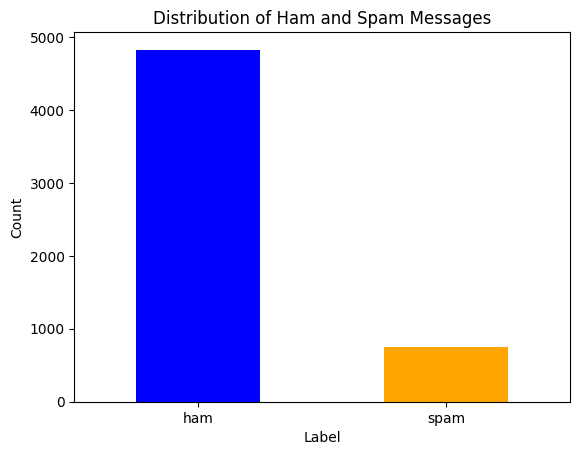

In [8]:
# Plotting the label distribution
label_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Ham and Spam Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Adding a column for message length
data['message_length'] = data['message'].apply(len)
data

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [10]:
# Descriptive statistics for message length
print(data.groupby('label')['message_length'].describe())

        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


# Plot the distribution of message lengths

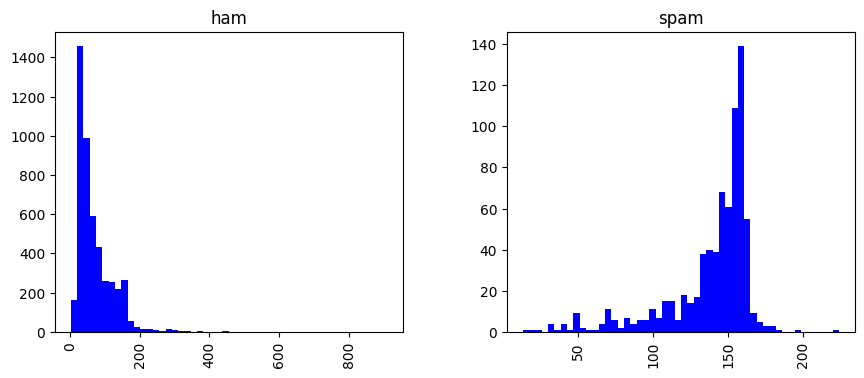

In [11]:
# Plotting message length distribution
data.hist(column='message_length', by='label', bins=50, color='blue', figsize=(10,4))
plt.show()

## Word Cloud of the spam and ham Messages

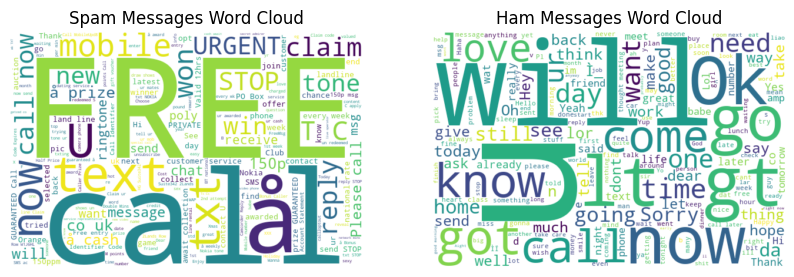

In [12]:


# Generating word clouds for spam and ham
spam_text = ' '.join(data[data['label'] == 'spam']['message'])
ham_text = ' '.join(data[data['label'] == 'ham']['message'])

spam_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(spam_text)
ham_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(ham_text)

# Displaying the word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.show()


# Data Preprocessing and Splitting

In [13]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [14]:
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())  # Lemmatization
    return text

In [15]:
train_data['message'] = train_data['message'].apply(preprocess_text)
test_data['message'] = test_data['message'].apply(preprocess_text)

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=100000)

In [17]:
X_train = tfidf_vectorizer.fit_transform(train_data['message'])
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 31948 stored elements and shape (4457, 6846)>

In [18]:
X_test = tfidf_vectorizer.transform(test_data['message'])
X_test 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7041 stored elements and shape (1115, 6846)>

In [19]:
# Encode the target labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['label'])

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=100000)

In [21]:
# Further split the training data into a training and validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Naive Bayes model

In [22]:
# Training a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_split, y_train_split)

MultinomialNB()

In [23]:
y_val_pred_nb = model.predict(X_val_split)
print("Naive Bayes Model Evaluation:")
print(classification_report(y_val_split, y_val_pred_nb, target_names=encoder.classes_))
print(f'Accuracy: {accuracy_score(y_val_split, y_val_pred_nb):.4f}\n')

Naive Bayes Model Evaluation:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       794
        spam       1.00      0.71      0.83        98

    accuracy                           0.97       892
   macro avg       0.98      0.86      0.91       892
weighted avg       0.97      0.97      0.97       892

Accuracy: 0.9686



In [24]:
# Compute the confusion matrix
confusion_matrixx= confusion_matrix(y_val_split, y_val_pred_nb)
confusion_matrixx

array([[794,   0],
       [ 28,  70]])

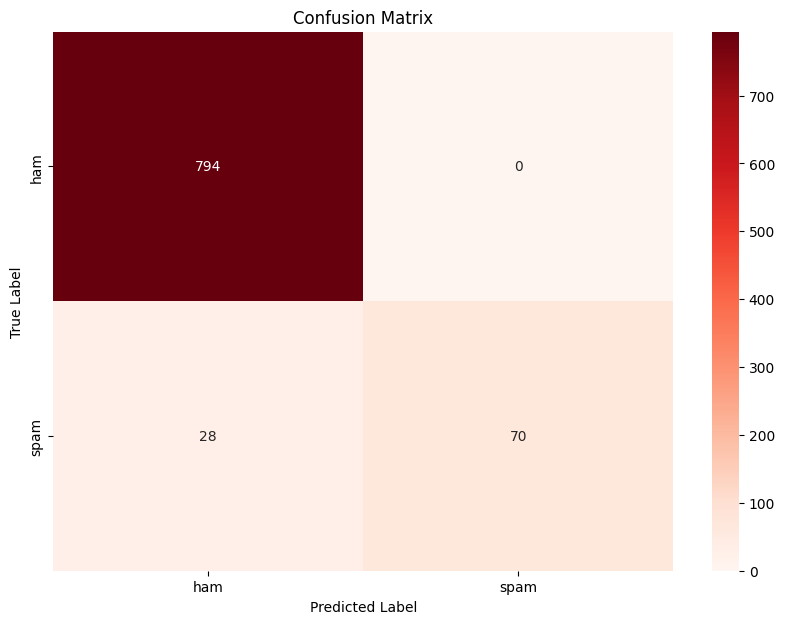

In [25]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrixx, annot=True, fmt='d', cmap='Reds', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression model

In [26]:
lr_model = LogisticRegression()
lr_model.fit(X_train_split, y_train_split)

LogisticRegression()

In [27]:
y_val_pred_lr = lr_model.predict(X_val_split)
print("Logistic Regression Model Evaluation:")
print(classification_report(y_val_split, y_val_pred_lr, target_names=encoder.classes_))
print(f'Accuracy: {accuracy_score(y_val_split, y_val_pred_lr):.4f}\n')

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       794
        spam       1.00      0.60      0.75        98

    accuracy                           0.96       892
   macro avg       0.98      0.80      0.86       892
weighted avg       0.96      0.96      0.95       892

Accuracy: 0.9563



# SVC model

In [28]:
svc_model = LinearSVC()
svc_model.fit(X_train_split, y_train_split)

LinearSVC()

In [29]:

# Validate the model
y_val_pred_svc = svc_model.predict(X_val_split)
print("Linear SVC Model Evaluation:")
print(classification_report(y_val_split, y_val_pred_svc, target_names=encoder.classes_))
print(f'Accuracy: {accuracy_score(y_val_split, y_val_pred_svc):.4f}\n')


Linear SVC Model Evaluation:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       794
        spam       0.97      0.80      0.88        98

    accuracy                           0.98       892
   macro avg       0.98      0.90      0.93       892
weighted avg       0.98      0.98      0.97       892

Accuracy: 0.9753



In [30]:
# Compute the confusion matrix
confusion_matrixx= confusion_matrix(y_val_split, y_val_pred_svc)
confusion_matrixx

array([[792,   2],
       [ 20,  78]])

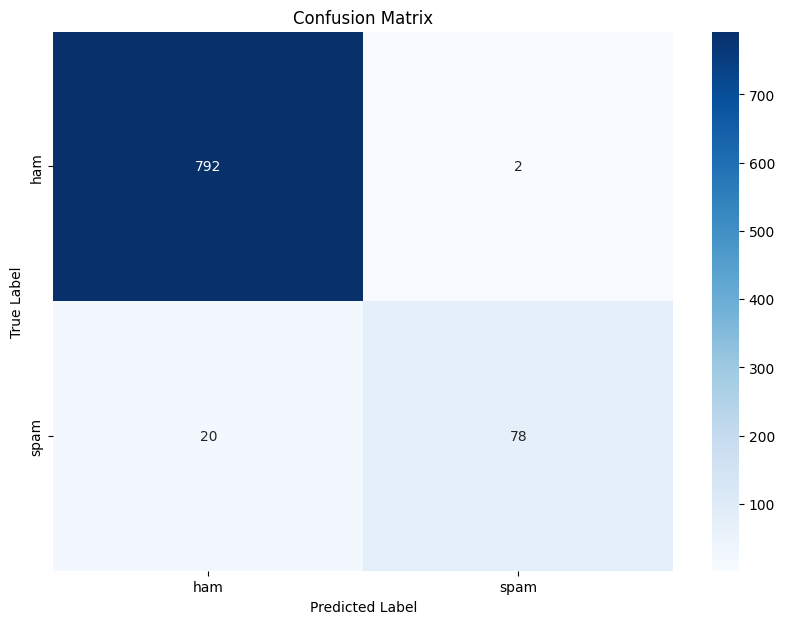

In [31]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrixx, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Make predictions on the test data using the Support Vector Machine Model

In [36]:
# Predict on the test set
y_test_pred = svc_model.predict(X_test)

# Decode the predicted labels to actual labels
y_test_pred_labels = encoder.inverse_transform(y_test_pred)

# Add predictions to the test data
test_data['Predicted_label'] = y_test_pred_labels

# Display the 3rd, 4th, and 5th rows of the test data with predictions
rows_to_display = [3, 4, 5, 6]  # Indices for 3rd, 4th, and 5th rows (indexing starts at 0)
selected_rows = test_data.iloc[rows_to_display][['label', 'Predicted_label']]
print(selected_rows)

     label Predicted_label
2484   ham             ham
812   spam            spam
2973   ham             ham
2991   ham             ham


## Predict the label of the new message

In [37]:

new_message = ("This is the 2nd time we have tried 2 contact u. U have won the �750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.,,,")

In [42]:
def predict_label(svc_model, description):
    processed_message = preprocess_text(description)
    X_input = tfidf_vectorizer.transform([processed_message])
    predicted_label_encoded = svc_model.predict(X_input)
    predicted_label = encoder.inverse_transform(predicted_label_encoded)
    return predicted_label[0]

predicted_label = predict_label(svc_model, new_message)
print(f"The predicted label for the message is: {predicted_label}")

The predicted label for the message is: ham


# Saving the SVC Model

In [43]:
import pickle

# Save the trained Random Forest pipeline to a file
with open('svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

In [44]:
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)